# Prediction of density in basalts of the Serra Geral Group

- Joao Paulo G. R. Alves - 2024
- joao (dot) guilherme (dot) alves (at) usp (dot) br
- Institute of Energy and Environment - University of Sao Paulo
- This is the full research script, meaning some of the stuff her was not used in the final paper

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import PredictionErrorDisplay
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde, pearsonr
import scipy.stats as stats
import statsmodels.api as sm
import shap
import warnings
import os
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# Importing the well logs
cols = ['well', 'depth', 'dt', 'gr', 'res', 'sp', 'rhob']
rch = pd.read_excel('WellLogs_1_RCH_1_SC_dens__SG.xlsx', usecols = cols)
tp = pd.read_excel('WellLogs_1_TP_3_SC_dens__SG.xlsx', usecols = cols)
hv = pd.read_excel('WellLogs_1_HV_1_SC_dens__SG.xlsx', usecols = cols)

In [3]:
# Concating into one dataframe
data = pd.concat([rch, tp, hv])

In [4]:
# Droping unecessary data
data.drop(['depth', 'well'], axis=1, inplace=True)

In [5]:
# Reordering the columns
data = data[['dt', 'gr', 'res', 'sp', 'rhob']]

In [6]:
data.head()

,dt,gr,res,sp,rhob
0,121.577621,69.139801,0.037094,195.820801,2.327105
1,68.416580,77.543839,0.008055,189.445953,2.337859
2,76.521362,88.664368,0.001220,181.946106,2.334926
3,128.297180,99.759918,0.000663,174.508759,2.316593
4,123.315231,107.531784,0.000429,165.571442,2.286772


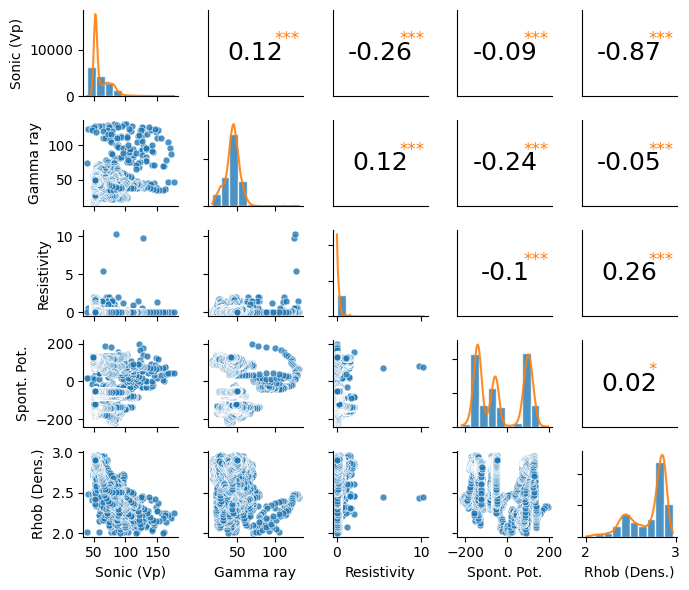

In [7]:
labels = ['Sonic (Vp)', 'Gamma ray', 'Resistivity', 'Spont. Pot.', 'Rhob (Dens.)']

# corrdot function to plot correlation coefficient
def corrdot(x, y, ax=None, **kwargs):
    corr_r = x.corr(y, 'pearson')
    corr_text = round(corr_r, 2)
    if ax is not None:
        ax.annotate(corr_text, xy=(0.5, 0.5), xycoords="axes fraction",
                    ha='center', va='center', fontsize=18)

# corrfunc function to plot significance stars
def corrfunc(x, y, ax=None, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05: p_stars = '*'
    if p <= 0.01: p_stars = '**'
    if p <= 0.001: p_stars = '***'
    if ax is not None:
        ax.annotate(p_stars, xy=(0.7, 0.6), xycoords="axes fraction",
                    color='tab:orange', fontsize=12)  # Adjusted for better visibility

# Number of variables
n = len(data.columns)

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(7, 6))

# Plot each pair of variables
for i in range(n):
    for j in range(n):
        ax = axs[i, j]
        if i == j:  # Diagonal plot with histogram and KDE
             # Histogram without density normalization
            counts, bins, patches = axs[i, j].hist(data[data.columns[i]], bins=10, color='tab:blue', alpha = 0.8, edgecolor='white')
            if j == 0:
                axs[i, j].xaxis.set_ticklabels([])
            elif j == n-1:
                axs[i, j].yaxis.set_ticklabels([])
            else:
                axs[i, j].xaxis.set_ticklabels([])
                axs[i, j].yaxis.set_ticklabels([])
            # KDE
            kde = gaussian_kde(data[data.columns[i]])
            x_range = np.linspace(bins.min(), bins.max(), 100)

            # Scale KDE by the count to match histogram scale
            kde_values = kde(x_range) * sum(counts) * np.diff(bins)[0]

            axs[i, j].plot(x_range, kde_values, color='tab:orange', alpha = 0.9)
            
        elif j > i:
            # Correctly pass the axis to the functions
            corrdot(data[data.columns[i]], data[data.columns[j]], ax=ax)
            corrfunc(data[data.columns[i]], data[data.columns[j]], ax=ax)
            axs[i, j].set_facecolor('white')
            for spine in axs[i, j].spines.values():
                spine.set_visible(True)
                spine.set_color('black')
            axs[i, j].tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
        else:
            axs[i, j].scatter(data[data.columns[j]], data[data.columns[i]], color='tab:blue', 
                              edgecolor='white', alpha=0.8, linewidth=0.5, s = 25)

        # Add labels to the leftmost and bottom subplots
        if i == n - 1:
            axs[i, j].set_xlabel(labels[j])
                
        if j == 0:
            axs[i, j].set_ylabel(labels[i])
                
        axs[i, j].spines[['right', 'top']].set_visible(False)

        if i == n-1 and j != 0:
            axs[i, j].yaxis.set_ticklabels([])

        if j == 0 and i != n-1:
            axs[i, j].xaxis.set_ticklabels([])

        if i != n-1 and j != 0:
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
        
plt.tight_layout()
plt.show()

In [8]:
# Removing extreme outliers using Z-score
def z_score(x):
    return (x - np.mean(x)) / np.std(x)

data = data[(np.abs(z_score(data['dt'])) < 3) &
            (np.abs(z_score(data['gr'])) < 3) &
            (np.abs(z_score(data['res'])) < 3) &
            (np.abs(z_score(data['sp'])) < 3) &
            (np.abs(z_score(data['rhob'])) < 3)]

In [9]:
X = data.drop(columns = ['rhob'])
y = data['rhob']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
def preprocess_data(X, scale_transformer=None):
    # Copy the input DataFrame to avoid changes to the original data
    X_transformed = X.copy()

    # Apply yeo-johnson transformation
    if scale_transformer is None:
        # Initialize PowerTransformer with Box-Cox
        scale_transformer = PowerTransformer(method='yeo-johnson', standardize=True)  # standardize=False to only apply Box-Cox
        # Fit and transform the data
        X_transformed = scale_transformer.fit_transform(X_transformed)
    else:
        # Transform data using the existing transformer
        X_transformed = scale_transformer.transform(X_transformed)

    # Convert the transformed array back to a DataFrame
    X_transformed_df = pd.DataFrame(X_transformed, columns=X.columns, index=X.index)

    return X_transformed_df, scale_transformer

In [12]:
X_train_transformed, scaler1 = preprocess_data(X_train)

In [13]:
X_test_transformed, _ = preprocess_data(X_test, scaler1)

In [14]:
models = [
    (XGBRegressor(random_state=42), 
     # --- Final User-Specified Grid ---
     {'n_estimators': [100, 200, 300, 400],
      'learning_rate': [0.01, 0.1, 0.2, 0.5],
      'max_depth': [3, 4, 5, 6],
      'subsample': [0.6, 0.7, 0.8, 0.9],
      'min_child_weight': [1, 5, 10],
      'gamma': [0, 0.1, 0.2, 0.3, 0.4],
      'reg_alpha': [0, 0.1, 0.5, 1, 5],
      'reg_lambda': [0, 0.1, 0.5, 1, 5]}),

    (RandomForestRegressor(random_state=42), 
     # --- Expanded to match XGBoost's level ---
     {'n_estimators': [100, 200, 300, 400], 
      'max_features': ['sqrt', 'log2'],
      'max_depth': [4, 6, 8, 10], 
      'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4]}),

    (GradientBoostingRegressor(random_state=42), 
     # --- Expanded to match XGBoost's level ---
     {'n_estimators': [100, 200, 300, 400], 
      'learning_rate': [0.01, 0.1, 0.2], 
      'max_depth': [3, 4, 5, 6], 
      'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4], 
      'subsample': [0.6, 0.7, 0.8, 0.9]}),
     
    (SVR(), 
     {'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 0.2], 'kernel': ['rbf', 'linear']}),

    (LinearRegression(), {}),

    (Ridge(), 
     {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}),

    (Lasso(), 
     {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}),
    
    (ExtraTreeRegressor(random_state=42), 
     # --- Expanded to be more comprehensive ---
     {'max_depth': [4, 6, 8, 10], 
      'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4]}),

    (DecisionTreeRegressor(random_state=42), 
     # --- Expanded to be more comprehensive ---
     {'max_depth': [4, 6, 8, 10], 
      'min_samples_split': [2, 5, 10], 
      'min_samples_leaf': [1, 2, 4]}),
      
    (BaggingRegressor(random_state=42), 
     {'n_estimators': [50, 100, 200], 
      'max_samples': [0.7, 0.8, 0.9, 1.0], 
      'max_features': [0.7, 0.8, 0.9, 1.0]})
]

In [15]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
results = []

In [ ]:
for model, param_grid in models:
    model_name = model.__class__.__name__
    random_search = RandomizedSearchCV(estimator=model, 
                                       param_distributions=param_grid,  
                                       cv=cv_strategy,
                                       n_iter=10,
                                       verbose=2,
                                       random_state=42,  
                                       scoring='neg_root_mean_squared_error')
    
    random_search.fit(X_train_transformed, y_train)
    best_model = random_search.best_estimator_
    predictions = best_model.predict(X_test_transformed)
    
    r2 = r2_score(y_test, predictions)
    rmse = root_mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    results.append([model_name, rmse, mae, r2])

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END gamma=0, learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=0.9; total time=   0.2s
[CV] END gamma=0, learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END gamma=0, learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END gamma=0, learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END gamma=0, learning_rate=0.5, max_depth=4, min_child_weight=1, n_estimators=200, reg_alpha=5, reg_lambda=1, subsample=0.9; total time=   0.1s
[CV] END gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=10, n_estimators=100, reg_alpha=1, reg_lambda=0, subsample=0.6; total time=   0.0s
[CV] END gamma=0, learning_rate=0.01, max_d

In [18]:
results_df = pd.DataFrame(results, columns=['Model', 'RMSE', 'MAE', 'R2'])

In [19]:
results_df.sort_values(by='RMSE', ascending=True, inplace=True)

In [20]:
print("Model Performance Comparison:")
print(results_df.to_string(index=False))

Model Performance Comparison:
                    Model     RMSE      MAE       R2
         BaggingRegressor 0.049867 0.031010 0.932408
GradientBoostingRegressor 0.051403 0.034843 0.928181
    RandomForestRegressor 0.055881 0.037533 0.915123
             XGBRegressor 0.057874 0.039458 0.908960
    DecisionTreeRegressor 0.063321 0.040362 0.891018
                      SVR 0.064397 0.041658 0.887282
       ExtraTreeRegressor 0.069619 0.046534 0.868262
         LinearRegression 0.087830 0.066295 0.790325
                    Ridge 0.087830 0.066295 0.790325
                    Lasso 0.089042 0.066950 0.784499
